In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
# Define the plotting function for the loss curve

def plot_the_loss_curve(epochs, mae_training):

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
    plt.legend()

    merged_mae_lists = mae_training[1:]
    highest_loss = max(merged_mae_lists)
    lowest_loss = min(merged_mae_lists)
    delta = highest_loss - lowest_loss
    print(delta)

    top_of_y_axis = highest_loss + (delta * 0.05)
    bottom_of_y_axis = lowest_loss - (delta * 0.05)

    plt.ylim([bottom_of_y_axis, top_of_y_axis])
    plt.show()

# Define the functions that will train and build the model

def train_model(model, dataset, epochs, label_name,
                batch_size=None):
    # Split the dataset into features and label.
    # Didn't fully understand this next line yet (copy pasted it). Will try to find out a better way to do it.
    features = {name: np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                        epochs=epochs, shuffle=True)

    epochs = history.epoch

    # Gather a snapshot of the model's mean squared error at each epoch.
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse


def create_model(my_learning_rate, my_feature_layer):
    # Simple tf.keras.Sequential
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(my_feature_layer)

    model.add(tf.keras.layers.Dense(units=256,
                                    activation='relu',
                                    name='Hidden1'))

    # tf.keras.activations.tanh is another possible activation function

    model.add(tf.keras.layers.Dense(units=256,
                                    activation='relu',
                                    name='Hidden2'))

    model.add(tf.keras.layers.Dense(units=1,
                                    name='Output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

# Define the analytical solution
# Simple beam (pinned support and roller support on each end) with length l, uniform load q
# moment of inertia of its section I and Young's modulus E.


def ana_sol(x, q, l, E, I):
    y = np.zeros(len(x))
    c_1 = -(q * l**3) / (24*E*I)
    y = (1/(E*I)) * (((q*l)/12) * x**3 - (q/24) * x**4) + c_1 * x

    return y

In [3]:
# Create ficticious points

x_min = 0
x_max = 1
n = 1000  # number of points
x_vec = np.linspace(x_min, x_max, n)

l = x_max - x_min
q = 10 * 10**4
E = 210 * 10**9
I = 2 * 10**(-5)
y_vec = ana_sol(x_vec, q, l, E, I) * 10**3  # [mm]

# Add noise
noise_factor = 0.1
y_vec = y_vec + noise_factor * (np.random.random(len(y_vec)) - 0.5) * (np.max(y_vec) - np.min(y_vec))

points = np.zeros((len(x_vec), 2))

for i in range(len(x_vec)):
    points[i, 0] = x_vec[i]
    points[i, 1] = y_vec[i]

# Create a Pandas Data Frame with the points
df = pd.DataFrame(data=points, columns=['x_vec', 'y_vec'])
df = df.reindex(np.random.permutation(df.index))  # shuffle the points

# Append x_vec to feature columns. Still need to find out if this is completely necessary.
feature_columns = []
x_col = tf.feature_column.numeric_column("x_vec")
feature_columns.append(x_col)

# Convert the list of feature columns into a layer
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [6]:

# Tune the hyperparameters of the model
learning_rate = 0.01
epochs = 80
batch_size = int(n/2)

label_name = "y_vec"

my_model = create_model(learning_rate, my_feature_layer)

epochs, mse = train_model(my_model, df, epochs,
                          label_name, batch_size)


Train on 1000 samples
Epoch 1/80
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0791 - mean_squared_error: 0.0791
Epoch 2/80
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0256 - mean_squared_error: 0.0256
Epoch 3/80
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0249 - mean_squared_error: 0.0249
Epoch 4/80
1000/1000 [==============================] - 0s 32us/sample - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 5/80
1000/1000 [==============================] - 0s 26us/sample - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 6/80
1000/1000 [==============================] - 0s 26us/sample - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 7/80
1000/1000 [==============================] - 0s 27us/sample - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 8/80
1000/1000 [==============================] - 0s 34us/sample - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 9/80
1000/1000 [==============================] - 0s 

1000/1000 [==============================] - 0s 14us/sample - loss: 7.7955e-05 - mean_squared_error: 7.7955e-05
Epoch 68/80
1000/1000 [==============================] - 0s 13us/sample - loss: 7.9593e-05 - mean_squared_error: 7.9593e-05
Epoch 69/80
1000/1000 [==============================] - 0s 14us/sample - loss: 7.8998e-05 - mean_squared_error: 7.8998e-05
Epoch 70/80
1000/1000 [==============================] - 0s 15us/sample - loss: 7.8661e-05 - mean_squared_error: 7.8661e-05
Epoch 71/80
1000/1000 [==============================] - 0s 14us/sample - loss: 8.0528e-05 - mean_squared_error: 8.0528e-05
Epoch 72/80
1000/1000 [==============================] - 0s 14us/sample - loss: 7.8491e-05 - mean_squared_error: 7.8491e-05
Epoch 73/80
1000/1000 [==============================] - 0s 14us/sample - loss: 7.7734e-05 - mean_squared_error: 7.7734e-05
Epoch 74/80
1000/1000 [==============================] - 0s 16us/sample - loss: 8.0869e-05 - mean_squared_error: 8.0869e-05
Epoch 75/80
1000/100

0.025527848076308146


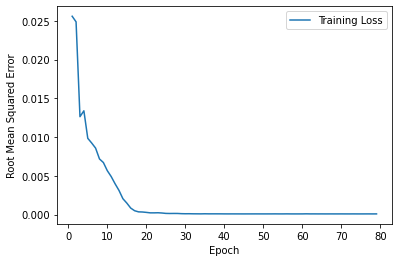

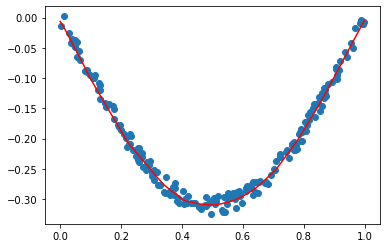

In [7]:
plot_the_loss_curve(epochs, mse)

# Plot a sample of the fictional points and the ML solution curve
sample_df = df.sample(int(n/5))
plt.scatter(sample_df['x_vec'], sample_df['y_vec'])

df['y_vec'] = np.zeros(len(y_vec))

# Had some problems here, because my_model.predict only takes a 'dict' as argument and not a np.array
# Probably related to my problems in the function train_model.
y_sol = my_model.predict({name: np.sort(np.array(value)) for name, value in df.items()})
plt.plot(x_vec, y_sol, c='r')
plt.show()

# It now gives a warning because the 'dict' has two inputs, but I can't seem to make it work right yet.

In [10]:
# We will now estimate the Young's (E) modulus of the beam using the ML model.
# This is done by calculating the average of estimated Es for each point (x_vec[i], y_sol[i]).
# We assume that the length of the beam (l), the load (q) and the moment of inercia (I) are known.

sum_E = 0
for i in range(n):
    sum_E = sum_E + (((q * l) / 12) * x_vec[i] ** 3 - (q / 24) * x_vec[i] ** 4 - (q * l**3 * x_vec[i]) / 24) / (y_sol[i] * 10**(-3) * I)

avg_E = sum_E/n
print("Estimated E: ", avg_E)
print("True E: ", E)
print("Relative error: ", abs(avg_E - E)/E)
print('\n')

# Now the same for the moment of inertia, considering E is known.

sum_I = 0
for i in range(n):
    sum_I = sum_I + (((q * l) / 12) * x_vec[i] ** 3 - (q / 24) * x_vec[i] ** 4 - (q * l**3 * x_vec[i]) / 24) / (y_sol[i] * 10**(-3) * E)

avg_I = sum_I/n
print("Estimated Iz: ", avg_I)
print("True Iz: ", I)
print("Relative error: ", abs(avg_I - I)/I)

Estimated E:  [2.035162e+11]
True E:  210000000000
Relative error:  [0.03087524]


Estimated Iz:  [1.93824979e-05]
True Iz:  2e-05
Relative error:  [0.0308751]


In [ ]:
# You have a model that fits very well a region of xy points. It such a model trained, and knowing the nature of those
#xy points, you were able to estimate some parameters related with the generationn of the xy data (E and I). However,
# to do that you used the euler-bernoulli equation, which is what we want to avoid.
#This is indeed the first step for a very interesting state of the art of new discoveries :)

# At this point let's rethink what would be fun to accomplish.
# Imagine if you have (x_vec,y_vec) data points for multiple combinations of (q, l, E, I)
# It such data, you could train a model in which the inputs are (x_vec,y_vec), and the outputs are (q, l, E, I).
# I such a model trained we could definetly predict q,L,E,and I without using any equations. 
#  task 1: generate fictcious combinations (>5000) of (q, l, E, I). set a range and number of valuers for each parameter, then iterate. (https://stackoverflow.com/questions/104420/how-to-generate-all-permutations-of-a-list)
#  task 2: split data into traininng, validation, and test sets (80%/15%/5%)
#  task 3: create and train a  deep neural network model, using trainninng and validation sets
#  task 4: evaluate the model with the test set.  
